In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pprint
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Dropout
import datetime
%matplotlib inline

In [3]:
df = pd.read_csv("AEP_hourly.csv")
print("="*50)
print("First Five Rows ","\n")
print(df.head(2),"\n")

print("="*50)
print("Information About Dataset","\n")
print(df.info(),"\n")

print("="*50)
print("Describe the Dataset ","\n")
print(df.describe(),"\n")

print("="*50)
print("Null Values t ","\n")
print(df.isnull().sum(),"\n")

First Five Rows  

              Datetime   AEP_MW
0  2004-12-31 01:00:00  13478.0
1  2004-12-31 02:00:00  12865.0 

Information About Dataset 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121273 entries, 0 to 121272
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  121273 non-null  object 
 1   AEP_MW    121273 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.9+ MB
None 

Describe the Dataset  

              AEP_MW
count  121273.000000
mean    15499.513717
std      2591.399065
min      9581.000000
25%     13630.000000
50%     15310.000000
75%     17200.000000
max     25695.000000 

Null Values t  

Datetime    0
AEP_MW      0
dtype: int64 



In [4]:
# Extract all Data Like Year MOnth Day Time etc
dataset = df
dataset["Month"] = pd.to_datetime(df["Datetime"]).dt.month
dataset["Year"] = pd.to_datetime(df["Datetime"]).dt.year
dataset["Date"] = pd.to_datetime(df["Datetime"]).dt.date
dataset["Time"] = pd.to_datetime(df["Datetime"]).dt.time
dataset["Week"] = pd.to_datetime(df["Datetime"]).dt.week
dataset["Day"] = pd.to_datetime(df["Datetime"]).dt.day_name()
dataset = df.set_index("Datetime")
dataset.index = pd.to_datetime(dataset.index)
dataset.head(1)

<ipython-input-4-71cefd3f5679>:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  dataset["Week"] = pd.to_datetime(df["Datetime"]).dt.week


,AEP_MW,Month,Year,Date,Time,Week,Day
Datetime,,,,,,,
2004-12-31 01:00:00,13478.0,12,2004,2004-12-31,01:00:00,53,Friday


In [5]:
# How many Unique Year do we Have in Dataset 
print(df.Year.unique(),"\n")
print("Total Number of Unique Year", df.Year.nunique(), "\n")

[2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017
 2018] 

Total Number of Unique Year 15 



No handles with labels found to put in legend.


Text(0.5, 1.0, 'Energy Consumption According to Year')

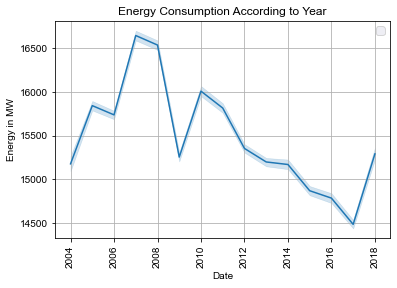

In [6]:
from matplotlib import style

fig = plt.figure()
ax1 = plt.subplot2grid((1,1), (0,0))

style.use('ggplot')

sns.lineplot(x=dataset["Year"], y=dataset["AEP_MW"], data=df)
sns.set(rc={'figure.figsize':(15,6)})

plt.title("Energy consumptionnin Year 2004")
plt.xlabel("Date")
plt.ylabel("Energy in MW")
plt.grid(True)
plt.legend()

for label in ax1.xaxis.get_ticklabels():
    label.set_rotation(90)


plt.title("Energy Consumption According to Year")

In [7]:
# from matplotlib import style


# fig = plt.figure()

# ax1= fig.add_subplot(311)
# ax2= fig.add_subplot(312)
# ax3= fig.add_subplot(313)


# style.use('ggplot')

# y_2004 = dataset["2004"]["AEP_MW"].to_list()
# x_2004 = dataset["2004"]["Date"].to_list()
# ax1.plot(x_2004,y_2004, color="green", linewidth=1.7)


# y_2005 = dataset["2005"]["AEP_MW"].to_list()
# x_2005 = dataset["2005"]["Date"].to_list()
# ax2.plot(x_2005, y_2005, color="green", linewidth=1)


# y_2006 = dataset["2006"]["AEP_MW"].to_list()
# x_2006 = dataset["2006"]["Date"].to_list()
# ax3.plot(x_2006, y_2006, color="green", linewidth=1)


# plt.rcParams["figure.figsize"] = (18,8)
# plt.title("Energy consumptionnin")
# plt.xlabel("Date")
# plt.ylabel("Energy in MW")
# plt.grid(True, alpha=1)
# plt.legend()

# for label in ax1.xaxis.get_ticklabels():
#     label.set_rotation(90)

C:\Users\jahna\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Ennergy Distribution')

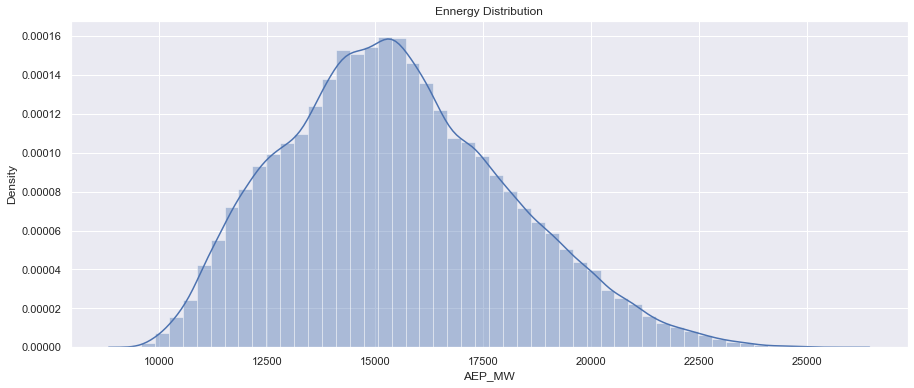

In [8]:
sns.distplot(dataset["AEP_MW"])
plt.title("Ennergy Distribution")

In [9]:
# fig = plt.figure()
# ax1= fig.add_subplot(111)

# sns.lineplot(x=dataset["Time"],y=dataset["AEP_MW"], data=df)
# plt.title("Energy Consumption vs Time ")
# plt.xlabel("Time")
# plt.grid(True, alpha=1)
# plt.legend()

# for label in ax1.xaxis.get_ticklabels():
#     label.set_rotation(90)

In [10]:
NewDataSet = dataset.resample('D').mean()

In [11]:
print("Old Dataset ",dataset.shape )
print("New  Dataset ",NewDataSet.shape )

Old Dataset  (121273, 7)
New  Dataset  (5055, 4)


In [12]:
TestData = NewDataSet.tail(100)

Training_Set = NewDataSet.iloc[:,0:1]

Training_Set = Training_Set[:-60]

In [13]:
print("Training Set Shape ", Training_Set.shape)
print("Test Set Shape ", TestData.shape)

Training Set Shape  (4995, 1)
Test Set Shape  (100, 4)


In [14]:
Training_Set = Training_Set.values
sc = MinMaxScaler(feature_range=(0, 1))
Train = sc.fit_transform(Training_Set)

In [15]:
X_Train = []
Y_Train = []

# Range should be fromm 60 Values to END 
for i in range(60, Train.shape[0]):
    
    # X_Train 0-59 
    X_Train.append(Train[i-60:i])
    
    # Y Would be 60 th Value based on past 60 Values 
    Y_Train.append(Train[i])

# Convert into Numpy Array
X_Train = np.array(X_Train)
Y_Train = np.array(Y_Train)

print(X_Train.shape)
print(Y_Train.shape)

(4935, 60, 1)
(4935, 1)


In [16]:
# Shape should be Number of [Datapoints , Steps , 1 )
# we convert into 3-d Vector or #rd Dimesnsion
X_Train = np.reshape(X_Train, newshape=(X_Train.shape[0], X_Train.shape[1], 1))
X_Train.shape

(4935, 60, 1)

In [17]:
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_Train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')


In [18]:
regressor.fit(X_Train, Y_Train, epochs = 50, batch_size = 32)

Epoch 1/50
155/155 [==============================] - 27s 171ms/step - loss: 0.0234
Epoch 2/50
155/155 [==============================] - 27s 173ms/step - loss: 0.0182
Epoch 3/50
155/155 [==============================] - 26s 165ms/step - loss: 0.0176
Epoch 4/50
155/155 [==============================] - 26s 166ms/step - loss: 0.0166
Epoch 5/50
155/155 [==============================] - 25s 162ms/step - loss: 0.0157
Epoch 6/50
155/155 [==============================] - 26s 165ms/step - loss: 0.01574s - loss: 
Epoch 7/50
155/155 [==============================] - 28s 183ms/step - loss: 0.0151
Epoch 8/50
155/155 [==============================] - 27s 173ms/step - loss: 0.0139
Epoch 9/50
155/155 [==============================] - 26s 169ms/step - loss: 0.0123
Epoch 10/50
155/155 [==============================] - 23s 147ms/step - loss: 0.0104
Epoch 11/50
155/155 [==============================] - 23s 147ms/step - loss: 0.0095
Epoch 12/50
155/155 [==============================] - 23s 148m

In [19]:
TestData.head(2)

,AEP_MW,Month,Year,Week
Datetime,,,,
2018-04-26,13157.791667,4,2018,17
2018-04-27,12964.000000,4,2018,17


In [20]:
TestData.shape

(100, 4)

In [21]:
NewDataSet.shape

(5055, 4)

In [22]:
Df_Total = pd.concat((NewDataSet[["AEP_MW"]], TestData[["AEP_MW"]]), axis=0)
Df_Total

,AEP_MW
Datetime,
2004-10-01,14284.521739
2004-10-02,12999.875000
2004-10-03,12227.083333
2004-10-04,14309.041667
2004-10-05,14439.708333
...,...
2018-07-30,15368.083333
2018-07-31,15180.291667
2018-08-01,15151.166667


In [23]:
Df_Total.shape

(5155, 1)

In [24]:
inputs = Df_Total[len(Df_Total) - len(TestData) - 60:].values
inputs.shape

(160, 1)

In [25]:
inputs = Df_Total[len(Df_Total) - len(TestData) - 60:].values

# We need to Reshape
inputs = inputs.reshape(-1,1)

# Normalize the Dataset
inputs = sc.transform(inputs)

X_test = []
for i in range(60, 160):
    X_test.append(inputs[i-60:i])
    
# Convert into Numpy Array
X_test = np.array(X_test)

# Reshape before Passing to Network
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Pass to Model 
predicted_stock_price = regressor.predict(X_test)

# Do inverse Transformation to get Values 
predicted_stock_price = sc.inverse_transform(predicted_stock_price)


In [26]:
True_MegaWatt = TestData["AEP_MW"].to_list()
Predicted_MegaWatt  = predicted_stock_price
dates = TestData.index.to_list()

In [27]:
Machine_Df = pd.DataFrame(data={
    "Date":dates,
    "TrueMegaWatt": True_MegaWatt,
    "PredictedMeagWatt":[x[0] for x in Predicted_MegaWatt ]
})

In [28]:
Machine_Df

,Date,TrueMegaWatt,PredictedMeagWatt
0,2018-04-26,13157.791667,13636.374023
1,2018-04-27,12964.000000,13470.775391
2,2018-04-28,12237.583333,14793.090820
3,2018-04-29,12156.791667,13426.840820
4,2018-04-30,13443.500000,13114.024414
...,...,...,...
95,2018-07-30,15368.083333,15538.978516
96,2018-07-31,15180.291667,15849.180664
97,2018-08-01,15151.166667,15187.882812
98,2018-08-02,15687.666667,15354.571289


In [29]:
True_MegaWatt = TestData["AEP_MW"].to_list()
Predicted_MegaWatt  = [x[0] for x in Predicted_MegaWatt ]
dates = TestData.index.to_list()

No handles with labels found to put in legend.


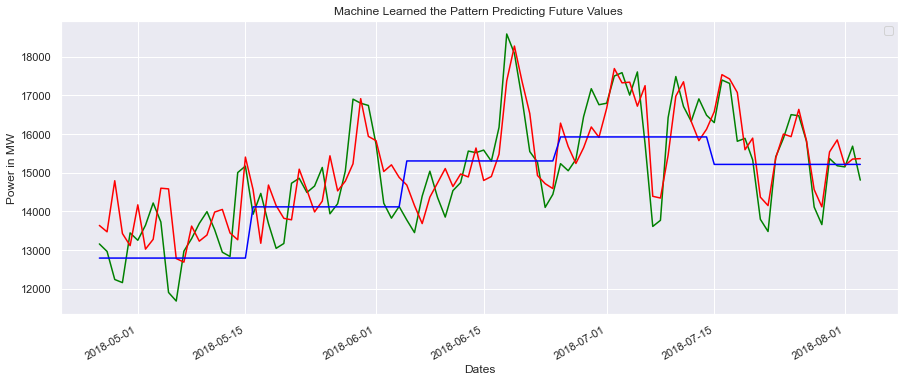

In [35]:
fig = plt.figure()

ax1= fig.add_subplot(111)

x = dates
y = True_MegaWatt

y1 = Predicted_MegaWatt

Testing = Machine_Df
Testing['Date'] = pd.to_datetime(Testing['Date'])
Testing = Testing.set_index('Date')
Testing = Testing.resample('MS').mean()
temp = Testing['TrueMegaWatt'].values.tolist()
temp2 = []
for a in temp:
    temp2.append(a)
    temp2.append(a)
    temp2.append(a)
    temp2.append(a)
    temp2.append(a)
    temp2.append(a)
    temp2.append(a)
    temp2.append(a)
    temp2.append(a)
    temp2.append(a)
    temp2.append(a)
    temp2.append(a)
    temp2.append(a)
    temp2.append(a)
    temp2.append(a)
    temp2.append(a)
    temp2.append(a)
    temp2.append(a)
    temp2.append(a)
    temp2.append(a)

plt.plot(x,y, color="green")
plt.plot(x,y1, color="red")
plt.plot(x, temp2, color="blue")
# beautify the x-labels
plt.gcf().autofmt_xdate()
plt.xlabel('Dates')
plt.ylabel("Power in MW")
plt.title("Machine Learned the Pattern Predicting Future Values ")
plt.legend()

In [36]:
baseprice = Machine_Df
baseprice['Date'] = pd.to_datetime(baseprice['Date'])
baseprice = baseprice.set_index('Date')
baseprice = baseprice.resample('MS').mean()
baseprice

,TrueMegaWatt,PredictedMeagWatt
Date,,
2018-04-01,12791.933333,13688.221094
2018-05-01,14117.005376,14206.766444
2018-06-01,15305.250000,15391.093978
2018-07-01,15926.622312,16074.285849
2018-08-01,15215.944444,15302.702148


In [50]:
for a in range(0, 100):
    if dates[a] < baseprice.at[0,'Date']:
        base_price = baseprice['TrueMegaWatt'][0]
    elif dates[a] < baseprice['Date'].values[1]:
        base_price = baseprice['TrueMegaWatt'][1]
    elif dates[a] < baseprice['Date'].values[2]:
        base_price = baseprice['TrueMegaWatt'][2]
    elif dates[a] < baseprice['Date'].values[3]:
        base_price = baseprice['TrueMegaWatt'][3]
    elif dates[a] < baseprice['Date'].values[4]:
        base_price = baseprice['TrueMegaWatt'][4]

print(base_price)

,TrueMegaWatt,PredictedMeagWatt
Date,,
2018-04-01,12791.933333,13688.221094
2018-05-01,14117.005376,14206.766444
2018-06-01,15305.250000,15391.093978
2018-07-01,15926.622312,16074.285849
2018-08-01,15215.944444,15302.702148
